In [1]:
pip install opencv-python numpy matplotlib scikit-image scikit-learn

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



# Task 1

In [3]:
# Load a color image
image = cv2.imread('image_1.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [4]:
# Convert to Binary (Black-and-White)
_, bw_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

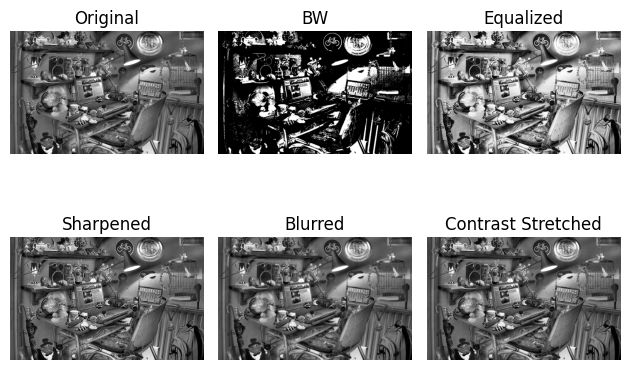

In [5]:
# 4 Enhancement techniques:
equalized = cv2.equalizeHist(gray_image)
sharpen_kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
sharpened = cv2.filter2D(gray_image, -1, sharpen_kernel)
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
contrast_stretched = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX)

# Plot
titles = ['Original', 'BW', 'Equalized', 'Sharpened', 'Blurred', 'Contrast Stretched']
images = [gray_image, bw_image, equalized, sharpened, blurred, contrast_stretched]

for i in range(6):
    plt.subplot(2, 3, i+1), plt.imshow(images[i], cmap='gray')
    plt.title(titles[i]), plt.axis('off')
plt.tight_layout()
plt.show()


#Task 2

In [6]:
# Load noisy image
noisy = cv2.imread('image_3.png', cv2.IMREAD_GRAYSCALE)

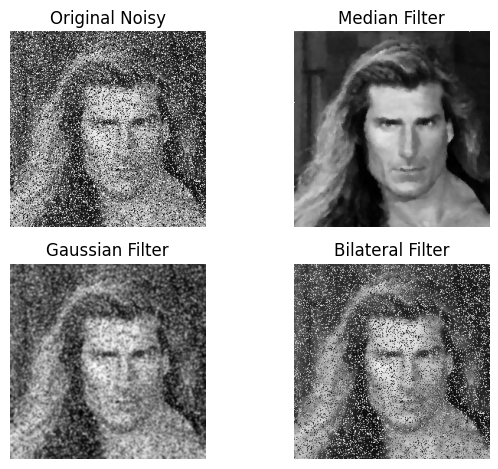

In [7]:
# Apply filters
median = cv2.medianBlur(noisy, 5)
gaussian = cv2.GaussianBlur(noisy, (5, 5), 0)
bilateral = cv2.bilateralFilter(noisy, 9, 75, 75)

# Plot
titles = ['Original Noisy', 'Median Filter', 'Gaussian Filter', 'Bilateral Filter']
images = [noisy, median, gaussian, bilateral]

for i in range(4):
    plt.subplot(2, 2, i+1), plt.imshow(images[i], cmap='gray')
    plt.title(titles[i]), plt.axis('off')
plt.tight_layout()
plt.show()


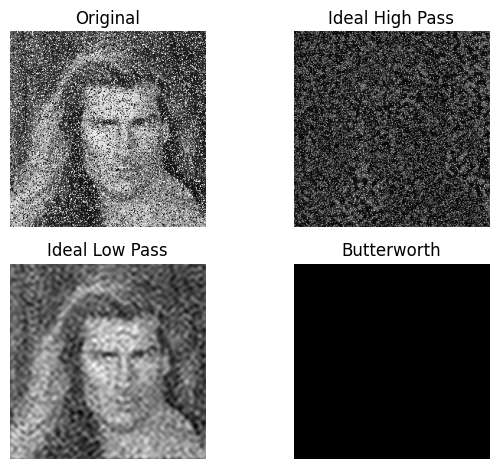

In [8]:
def apply_filter(img, type='low', cutoff=30, order=2):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img.shape
    crow, ccol = rows//2 , cols//2
    mask = np.zeros((rows, cols), np.uint8)

    if type == 'low':
        mask[crow-cutoff:crow+cutoff, ccol-cutoff:ccol+cutoff] = 1
    elif type == 'high':
        mask = np.ones((rows, cols), np.uint8)
        mask[crow-cutoff:crow+cutoff, ccol-cutoff:ccol+cutoff] = 0
    elif type == 'butterworth':
        for i in range(rows):
            for j in range(cols):
                dist = np.sqrt((i - crow)**2 + (j - ccol)**2)
                mask[i, j] = 1 / (1 + (cutoff / (dist + 1e-5))**(2 * order))

    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.abs(np.fft.ifft2(f_ishift))
    return img_back

ihp = apply_filter(noisy, type='high')
ilp = apply_filter(noisy, type='low')
butterworth = apply_filter(noisy, type='butterworth', order=2)

# Plot
titles = ['Original', 'Ideal High Pass', 'Ideal Low Pass', 'Butterworth']
images = [noisy, ihp, ilp, butterworth]

for i in range(4):
    plt.subplot(2, 2, i+1), plt.imshow(images[i], cmap='gray')
    plt.title(titles[i]), plt.axis('off')
plt.tight_layout()
plt.show()


#Task 3

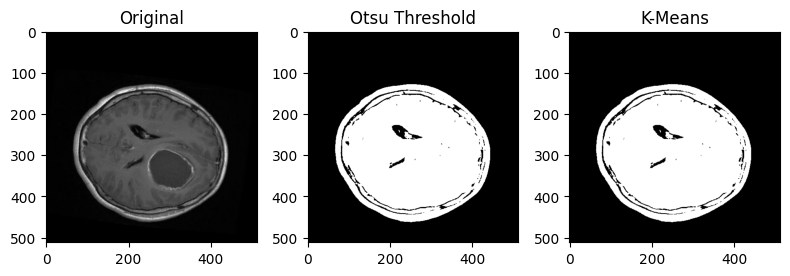

In [9]:
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu

image = cv2.imread('brain_glioma_1939.jpg', cv2.IMREAD_GRAYSCALE)

# Thresholding
thresh_val = threshold_otsu(image)
binary = image > thresh_val

# KMeans clustering
img_flat = image.reshape((-1, 1))
kmeans = KMeans(n_clusters=2, random_state=42).fit(img_flat)
clustered = kmeans.labels_.reshape(image.shape)

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1), plt.imshow(image, cmap='gray'), plt.title('Original')
plt.subplot(1, 3, 2), plt.imshow(binary, cmap='gray'), plt.title('Otsu Threshold')
plt.subplot(1, 3, 3), plt.imshow(clustered, cmap='gray'), plt.title('K-Means')
plt.tight_layout()
plt.show()


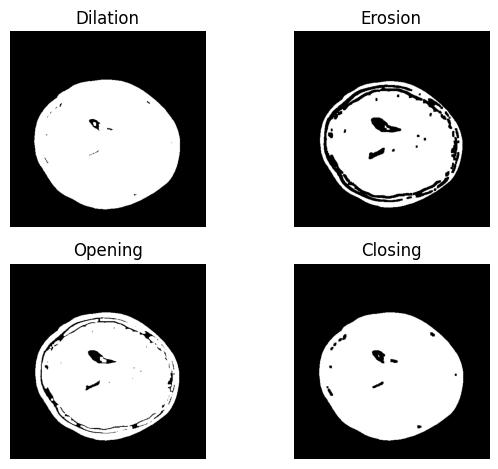

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilation = cv2.dilate(binary.astype(np.uint8), kernel, iterations=1)
erosion = cv2.erode(binary.astype(np.uint8), kernel, iterations=1)
opening = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

# Plot
titles = ['Dilation', 'Erosion', 'Opening', 'Closing']
images = [dilation, erosion, opening, closing]

for i in range(4):
    plt.subplot(2, 2, i+1), plt.imshow(images[i], cmap='gray')
    plt.title(titles[i]), plt.axis('off')
plt.tight_layout()
plt.show()


#Task 4

In [11]:
# ========== Imports ==========
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from google.colab import files
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import glob



In [12]:
import zipfile

zip_path = '/content/Brain cancer.zip'
extract_dir = "brain_cancer_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Confirm folder structure
for root, dirs, files in os.walk(extract_dir):
    print(root, ":", len(files), "files")



brain_cancer_dataset : 1 files
brain_cancer_dataset/Brain_Cancer raw MRI data : 0 files
brain_cancer_dataset/Brain_Cancer raw MRI data/Brain_Cancer : 0 files
brain_cancer_dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor : 2048 files
brain_cancer_dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma : 2004 files
brain_cancer_dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_menin : 2004 files


In [13]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops
from tqdm import tqdm

RESIZE_SHAPE = (256, 256)
base_dir = "brain_cancer_dataset/Brain_Cancer raw MRI data/Brain_Cancer"
classes = ['brain_glioma', 'brain_menin', 'brain_tumor']

def extract_features(image_path):
    features = {}
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, RESIZE_SHAPE)

    # Structural features
    _, binary = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    labeled_img = label(binary)
    props = regionprops(labeled_img)

    features['num_regions'] = len(props)
    if props:
        largest = max(props, key=lambda x: x.area)
        features['largest_area'] = largest.area
        features['eccentricity'] = largest.eccentricity
        features['solidity'] = largest.solidity
        features['extent'] = largest.extent
    else:
        features.update(dict(largest_area=0, eccentricity=0, solidity=0, extent=0))

    # Textural features
    glcm = graycomatrix(img_resized, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
    features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    features['ASM'] = graycoprops(glcm, 'ASM')[0, 0]
    features['energy'] = graycoprops(glcm, 'energy')[0, 0]
    features['correlation'] = graycoprops(glcm, 'correlation')[0, 0]

    return features


In [14]:
all_data = []

for cls in classes:
    print(f"Processing class: {cls}")
    folder_path = os.path.join(base_dir, cls)
    img_files = sorted(os.listdir(folder_path))  # Ensure consistent ordering

    for img_name in tqdm(img_files):
        img_path = os.path.join(folder_path, img_name)
        try:
            feats = extract_features(img_path)
            feats['label'] = cls
            all_data.append(feats)
        except Exception as e:
            print(f"Error: {img_name} - {e}")

df_all = pd.DataFrame(all_data)
df_all.to_csv("brain_mri_features.csv", index=False)
df_all.head()


Processing class: brain_glioma


100%|██████████| 2004/2004 [00:33<00:00, 59.38it/s]


Processing class: brain_menin


100%|██████████| 2004/2004 [00:32<00:00, 61.84it/s]


Processing class: brain_tumor


100%|██████████| 2048/2048 [00:39<00:00, 52.22it/s]


,num_regions,largest_area,eccentricity,solidity,extent,contrast,dissimilarity,homogeneity,ASM,energy,correlation,label
0,12,12767.0,0.345608,0.624761,0.517427,287.842910,6.473948,0.681100,0.408462,0.639110,0.781721,brain_glioma
1,25,26191.0,0.628365,0.831540,0.675618,717.285078,12.416490,0.463937,0.130063,0.360642,0.826547,brain_glioma
2,15,20843.0,0.721391,0.819816,0.700581,335.233939,8.005603,0.538398,0.114380,0.338201,0.846352,brain_glioma
3,18,30331.0,0.569464,0.890072,0.754409,381.637450,9.117841,0.500114,0.168991,0.411085,0.851557,brain_glioma
4,9,19875.0,0.440861,0.755359,0.587323,775.677135,12.216322,0.568203,0.258099,0.508035,0.777448,brain_glioma


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Prepare data
X = df_all.drop('label', axis=1)
y = LabelEncoder().fit_transform(df_all['label'])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [16]:
# Train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [17]:
# Predict
y_pred = model.predict(X_test)

In [23]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       425
           1       0.77      0.76      0.77       392
           2       0.84      0.85      0.85       395

    accuracy                           0.82      1212
   macro avg       0.82      0.82      0.82      1212
weighted avg       0.82      0.82      0.82      1212



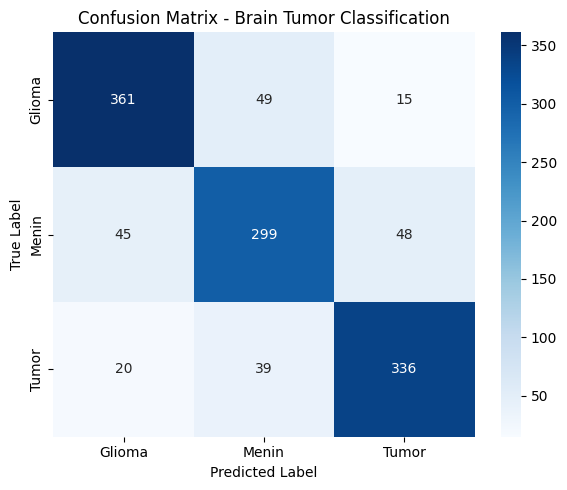

In [24]:
# Define the actual labels used in classification
labels = ['Glioma', 'Menin', 'Tumor']

# Example: Generate the confusion matrix using y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Brain Tumor Classification')
plt.tight_layout()
plt.show()